In [ ]:
# In The Name of God - 14/12/00
# Public to Reference Conversion by Simple Autoencoder - 1
# Dataset CelebA
# changes:
#   V2 - 15/12/1400 : models changed
#   V3 - 15/12/1400 : change loss for some features in encoder
#   V4 - 19/12/1400 : bug fixed! (in extract labels)
#   V5 - 19/12/1400 : accuracy and psnr added
#   V6 - 19/12/1400 : classifier added for seleced features
#   V7 - 20/12/1400 : bug fixed! (hair color classes changed to 4 class instead of 3 class)
#   V8 - 23/12/1400 : change hair color labels -> independent classes (6 bits)
#                   : change features loss function from BCE -> MSE (for hair color & gender) 
#   V9 - 14/09/1401 : remove hair color classifier for icee conference
#   V10- 15/10/1401 : change task attribute from gender to open_mouth
#   REV2-06/11/1401 : change loss function for classifier and correct some bugs in fit, valid and calc_accuracy function and g function for calculating labels and criterion

In [ ]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

In [ ]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files
isFirstRun = False
lastRunEpochNumber = 'last'
manual_seed = 20
image_size = 64
use_whole_dataset = True
usage_percent = 1.0 
celeba_male_index = 20
celeba_young_index = 39
celeba_smiling_index = 31
celeba_straight_hair_index = 32
celeba_wavy_hair_index = 33
# celeba_black_hair_index = 8
# celeba_blonde_hair_index = 9
# celeba_brown_hair_index = 11
# celeba_gray_hair_index = 17
celeba_eyeglasses_index = 15
celeba_chubby_index = 13

celeba_mouth_open_index = 21
celeba_high_cheekbone_index = 19

using_index = celeba_smiling_index

# decision_label = 39 # for young (labels[0][:, 39])  /  for male (labels[0][:, 20])
# ref_decision_label_val = 0 # male/young = 0 - means female/old
# fol_decision_label_val = 1 # male/young = 1 - means male/young
learning_rate = 0.001 #0.2
batch_size = 64
# ref_batch_size = batch_size
# fol_batch_size = batch_size  

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasetShortcuts/CelebA'
#'C:/Workspace/Datasets/CelebA'
#'D:/on going/server/CelebA'
# dataset_folder_path = 'drive/MyDrive/ML/datasetShortcuts/CelebA'
data_dir = 'celeba'
save_dir = 'p2r-ae-9rev2-G-S'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'
#'C:/Users/jamshidi/saveMLs/' + save_dir + '/'
#'C:/Users/Mohammad/savedML/' + save_dir + '/'
# saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

# use_early_stop = False
# use_rate_schedule = False
# use_dis_acc_stopper = True

# use_noise_in_input = False
# use_exact_pairing = True

# Other params
# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Size of feature maps in encoder
nef = 64
# Size of feature maps in decoder
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Number of training epochs
num_epochs = lastRunEpochNumber #100

In [ ]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
# download dataset and unzip
# data_dir variable: data_dir = 'img_align_celeba'

if files_not_ready:
    dataset_zip_path = dataset_folder_path + '/Img/img_align_celeba.zip'
    list_eval_partition_path = dataset_folder_path + '/Eval/list_eval_partition.txt'
    identity_celeba_path = dataset_folder_path + '/Anno/identity_CelebA.txt'
    list_attr_celeba_path = dataset_folder_path + '/Anno/list_attr_celeba.txt'
    list_bbox_celeba_path = dataset_folder_path + '/Anno/list_bbox_celeba.txt'
    list_landmarks_align_celeba_path = dataset_folder_path + '/Anno/list_landmarks_align_celeba.txt'

    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_zip_path, data_dir + r'/img_align_celeba.zip')
    shutil.copyfile(list_eval_partition_path, data_dir + r'/list_eval_partition.txt')
    shutil.copyfile(identity_celeba_path, data_dir + r'/identity_CelebA.txt')
    shutil.copyfile(list_attr_celeba_path, data_dir + r'/list_attr_celeba.txt')
    shutil.copyfile(list_bbox_celeba_path, data_dir + r'/list_bbox_celeba.txt')
    shutil.copyfile(list_landmarks_align_celeba_path, data_dir + r'/list_landmarks_align_celeba.txt')

    try:
        shutil.rmtree(data_dir + r'/img_align_celeba')
        print("old unzipped directory removed successfully")
    except OSError as e:
        print("Error: %s" % (e.strerror))

    archive = data_dir + r'/img_align_celeba.zip'
    with ZipFile(archive, 'r') as zip:
       zip.extractall(data_dir)
try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

data folder created successfully
Error: No such file or directory
saving_path directory created successfully


In [ ]:
#@title
# Class - Learning Rate Scheduler
class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [ ]:
#@title
# Class - Early Stopping
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    def __call__(self, score):
        if self.best_score == None:
            self.best_score = score
        elif self.best_score - score > self.min_delta:
            self.best_score = score
            self.counter = 0
        elif self.best_score - score < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
#@title
# Class - Discriminator accuracy stopper
class DisAccStopping():
    """
    Discriminator accuracy stopper to stop the training when the discriminator accuracy closes to 50%
    """
    def __init__(self, patience=5, min_delta=2):
        """
        :param patience: how many epochs to wait before stopping when accuracy is
               remain near 50%
        :param min_delta: minimum difference between accuracy and 50%
               to be considered as closeness
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        #self.best_score = None
        self.dis_acc_stop = False
    def __call__(self, score):
        if abs(score - 50) >= self.min_delta:
            self.counter = 0
        elif abs(score - 50) < self.min_delta:
            self.counter += 1
            print(f"INFO: Discriminator accuracy stopper counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Discriminator accuracy stopping')
                self.dis_acc_stop = True

In [ ]:
#@title
# Class - oneFeatureSampler

from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

class OneFeatureSampler(torch.utils.data.Sampler[int]):
    def __init__(self, mask) -> None:
        self.mask = mask
        self.indices = torch.nonzero(mask)
    def __iter__(self) -> Iterator[int]:
        for i in range(len(self.indices)):
            yield self.indices[i]
    def __len__(self) -> int:
        return len(self.indices)

In [ ]:
#@title
# Define transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [ ]:
#@title
# Function - use some percent of data
def shorten_dataset(dataset, usage_percent=1.0):
  len_used = floor(len(dataset)*usage_percent)
  len_not_used = len(dataset) - len_used
  used_dataset, not_used_dataset = random_split(dataset, [len_used, len_not_used], generator=torch.Generator().manual_seed(manual_seed)) 
  return used_dataset

In [ ]:
#@title
# Function - Split Data to Public & Private
def split_to_public_private(dataset, usage_percent=1.0, public_percent=0.25):
  len_used = floor(len(dataset)*usage_percent)
  len_not_used = len(dataset) - len_used
  used_dataset, not_used_dataset = random_split(dataset, [len_used, len_not_used], generator=torch.Generator().manual_seed(manual_seed)) 
  len_public = floor(len(used_dataset)*public_percent)
  len_private = len(used_dataset) - len_public
  return random_split(used_dataset, [len_public, len_private], generator=torch.Generator().manual_seed(manual_seed)) 
  

In [ ]:
#@title
# Function - Specialized DataLoader
def init_specialized_dataLoader(dataset, label, label_val, batch_size):
  if type(dataset) == torch.utils.data.dataset.Subset:
    mask = [1 if dataset.dataset.attr[:,label][i] == label_val else 0 for i in dataset.indices]
  else:
    mask = [1 if dataset.attr[:,label][i] == label_val else 0 for i in range(len(dataset))]
  mask = torch.tensor(mask)   
  sampler = OneFeatureSampler(mask)
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = sampler, shuffle=False, num_workers=workers, drop_last=True)

In [ ]:
#@title
# Load Datas
train_set = datasets.CelebA(root='', download=False, split='train', target_type=["attr", "identity"], transform=train_transforms)
test_set = datasets.CelebA(root='', download=False, split='test', target_type=["attr", "identity"], transform=test_transforms)
valid_set = datasets.CelebA(root='', download=False, split='valid', target_type=["attr", "identity"], transform=test_transforms)

# shorten Dataset
if not use_whole_dataset:
  train_set = shorten_dataset(train_set, usage_percent)
  test_set = shorten_dataset(test_set, usage_percent)
  valid_set = shorten_dataset(valid_set, usage_percent)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=workers, drop_last=True)


# ref DataLoader
# ref_train_loader = init_specialized_dataLoader(train_set, decision_label, ref_decision_label_val, ref_batch_size)
# ref_test_loader = init_specialized_dataLoader(test_set, decision_label, ref_decision_label_val, ref_batch_size)
# ref_valid_loader = init_specialized_dataLoader(valid_set, decision_label, ref_decision_label_val, ref_batch_size)

# fol DataLoader
# fol_train_loader = init_specialized_dataLoader(train_set, decision_label, fol_decision_label_val, fol_batch_size)
# fol_test_loader = init_specialized_dataLoader(test_set, decision_label, fol_decision_label_val, fol_batch_size)
# fol_valid_loader = init_specialized_dataLoader(valid_set, decision_label, fol_decision_label_val, fol_batch_size)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
# # Plot some images with corresponding labels
# first_batch = next(iter(train_loader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# # if use_whole_dataset:
# #     print((first_batch[1][0])[:,0,39])
# # else:
# print((first_batch[1][0])[:,39])

In [ ]:
#@title
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        
        # input is nc x 64 x 64 
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # split features: 1024 -> 1022 + 2 (male/female)
        # first classifier: (gender)
        self.fllc_male_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_male_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features1 = nn.Dropout(p=0.5)
        self.fllc_male_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_male_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features2 = nn.Dropout(p=0.5)
        self.fllc_male_features3 = nn.Linear(nef*4, nef)
        self.actv_male_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_male_features4 = nn.Linear(nef, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # second classifier: (hair color)
        # self.fllc_hair_color_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        # self.actv_hair_color_features1 = nn.LeakyReLU(0.2, inplace=True)
        # self.dropout_hair_color_features1 = nn.Dropout(p=0.5)
        # self.fllc_hair_color_features2 = nn.Linear(nef*1*4*4, nef*4)
        # self.actv_hair_color_features2 = nn.LeakyReLU(0.2, inplace=True)
        # self.dropout_hair_color_features2 = nn.Dropout(p=0.5)
        # self.fllc_hair_color_features3 = nn.Linear(nef*4, nef)
        # self.actv_hair_color_features3 = nn.LeakyReLU(0.2, inplace=True)
        # self.fllc_hair_color_features4 = nn.Linear(nef, 6)
        # self.actv_hair_color_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features1 = nn.Dropout(p=0.5)
        self.fllc_other_features2 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features2 = nn.Dropout(p=0.5)
        self.fllc_other_features3 = nn.Linear(nef*1*4*4, nef*1*4*4 - 2)
        self.actv_other_features3 = nn.LeakyReLU(0.2, inplace=True)
        # aggregate features for output

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # first classifier: (gender)
        y1 = self.fllc_male_features1(x)
        y1 = self.actv_male_features1(y1)
        y1 = self.dropout_male_features1(y1)
        y1 = self.fllc_male_features2(y1)
        y1 = self.actv_male_features2(y1)
        y1 = self.dropout_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # second classifier: (hair color)
        # y2 = self.fllc_hair_color_features1(x) 
        # y2 = self.actv_hair_color_features1(y2)
        # y2 = self.dropout_hair_color_features1(y2)
        # y2 = self.fllc_hair_color_features2(y2) 
        # y2 = self.actv_hair_color_features2(y2)
        # y2 = self.dropout_hair_color_features2(y2)
        # y2 = self.fllc_hair_color_features3(y2) 
        # y2 = self.actv_hair_color_features3(y2)
        # y2 = self.fllc_hair_color_features4(y2) 
        # y2 = self.actv_hair_color_features4(y2)
        # other features
        y3 = self.fllc_other_features1(x) 
        y3 = self.actv_other_features1(y3)
        y3 = self.dropout_other_features1(y3)
        y3 = self.fllc_other_features2(y3) 
        y3 = self.actv_other_features2(y3)
        y3 = self.dropout_other_features2(y3)
        y3 = self.fllc_other_features3(y3) 
        y3 = self.actv_other_features3(y3)
        return y1, y3

In [ ]:
# Decoder Model
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        
        # input size is 1024
        self.fllc6 = nn.Linear(nef*1*4*4, ndf*2*4*4)
        self.actv6 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 2048
        # shaping would be here: 2048 -> ndf*2 x 4 x 4
        # state size. (ndf*2) x 4 x 4
        self.cnvt7 = nn.ConvTranspose2d( ndf*2, ndf, 4, 2, 1, bias=False)
        self.bnor7 = nn.BatchNorm2d(ndf)
        self.actv7 = nn.ReLU(True)
        # state size. (ndf) x 8 x 8
        self.cnvt8 = nn.ConvTranspose2d(ndf, ndf, 4, 2, 1, bias=False)
        self.bnor8 = nn.BatchNorm2d(ndf)
        self.actv8 = nn.ReLU(True)
        # state size. (ndf) x 16 x 16
        self.cnvt9 = nn.ConvTranspose2d( ndf, ndf, 4, 2, 1, bias=False)
        self.bnor9 = nn.BatchNorm2d(ndf)
        self.actv9 = nn.ReLU(True)
        # state size. (ndf) x 32 x 32
        self.cnvt10 = nn.ConvTranspose2d( ndf, nc, 4, 2, 1, bias=False)
        self.actv10 = nn.Sigmoid() # nn.Tanh()
        # state size. (nc) x 64 x 64 

    def forward(self, x):
        x = self.fllc6(x)
        x = self.actv6(x)
        x = x.view(64, ndf*2, 4, 4) # 64 is batch_size
        x = self.cnvt7(x)
        x = self.bnor7(x)
        x = self.actv7(x)
        x = self.cnvt8(x)
        x = self.bnor8(x)
        x = self.actv8(x)
        x = self.cnvt9(x)
        x = self.bnor9(x)
        x = self.actv9(x)
        x = self.cnvt10(x)
        x = self.actv10(x)
        return x

In [ ]:
# AE Model
class AEModel(nn.Module):
    def __init__(self, ngpu):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def forward(self, x):
        # y1, y2, y3 = self.encoder(x)
        # y = torch.cat((y1, y2, y3), 1)
        # x = self.decoder(y)
        # return x, y1, y2
        y1, y3 = self.encoder(x)
        y = torch.cat((y1, y3), 1)
        x = self.decoder(y)
        return x, y1

In [ ]:
# Create the AE
netAE = AEModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netAE.apply(weights_init)

# Print the model
# print(netAE)

AEModel(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (actv1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bnor2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bnor3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bnor4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv4): LeakyReLU(negative_slope=0.2, inplace=True)
    (fllc5): Linear(in_features=2048, out_features=1024, bias=True)
    (actv5): LeakyReLU(negati

In [ ]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in netAE.parameters())
print(f"{total_params:,} training parameters.")

9,204,032 training parameters.


In [ ]:
# Initialize BCELoss function
criterion = nn.MSELoss()
criterion_male_features = nn.NLLLoss() # nn.MSELoss()
# criterion_hair_color_features = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(batch_size, 1, image_size, image_size, device=device)

# Establish convention for real(a real old - from reference dataset) and fake(a young which obfuscated to old - from follower dataset) labels during training
# ref_decision_label_val = 0 #from reference dataset (old)
# fol_decision_label_val = 1 #from follower dataset (young)

# Setup Adam optimizers for both O and D
optimizer = optim.Adam(netAE.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [ ]:
#@title
# Function - Save:
def save_model(name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [ ]:
#@title
# Function - Load:
def load_model(name, number, model, device):
  
  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [ ]:
#@title
# Function - Delete file:
def delete_file(name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [ ]:
# Save Start Checkpoint
# Comment It for next run!
if(isFirstRun):
  res = {'train_losses': [],
         'valid_losses': [],
         'y1_train_losses': [],
         'y1_valid_losses': [],
        #  'y2_train_losses': [],
        #  'y2_valid_losses': [],
         'test_mse': [],
         'test_psnr': [],
         'test_y1_acc': [],
        #  'test_y2_acc': [],
         #'accuracies': [],
         'epoch_number': 0
        };
  save_model('ae', 0, netAE, res)

In [ ]:
# Load Last Checkpoint:
ae_load = load_model('ae', lastRunEpochNumber, netAE, device)

train_losses = ae_load['res']['train_losses']
valid_losses = ae_load['res']['valid_losses']
y1_train_losses = ae_load['res']['y1_train_losses']
y1_valid_losses = ae_load['res']['y1_valid_losses']
# y2_train_losses = ae_load['res']['y2_train_losses']
# y2_valid_losses = ae_load['res']['y2_valid_losses']
test_mse = ae_load['res']['test_mse']
test_psnr = ae_load['res']['test_psnr']
test_y1_acc = ae_load['res']['test_y1_acc']
# test_y2_acc = ae_load['res']['test_y2_acc']
#accuracies = ae_load['res']['accuracies']
last_epoch = ae_load['res']['epoch_number']

In [ ]:
#@title
# either early stopping or learning rate scheduler or discriminator accuracy stopper
# if use_rate_schedule:
#     print('INFO: Learning rate scheduler is on')
#     lr_scheduler = LRScheduler(optimizer)

# if use_early_stop:
#     print('INFO: Early stopping is on')
#     early_stopping = EarlyStopping()

# if use_dis_acc_stopper:
#     print('INFO: Discriminator Accuracy stopping is on')
#     dis_acc_stopper = DisAccStopping()


In [ ]:
#@title
# Function - Random index for batch from loader
def rand_batch(before_loop, ref_iter):
  if before_loop:
    rand = random.randint(0, 40)
  else:
    rand = random.randint(1, 2)
  for i in range(rand):
    batch = next(ref_iter)
  return batch

In [ ]:
def fix_getting_data_problem(labels, decision_label):
    if use_whole_dataset:
        # return labels[0][:, 0, decision_label]
        return labels[0][:, decision_label]
    else:
        return labels[0][:, decision_label]

In [ ]:
def extract_targets(labels):
    male_labels = fix_getting_data_problem(labels, using_index)
    female_labels = torch.add(1, -male_labels)
    gender_target = torch.cat((male_labels.view(64,1), female_labels.view(64,1)), 1).float() # 64 is batch_size
    # gender_target = gender_labels.float()#.softmax(dim=1) #gender_labels.float().softmax(dim=1)
    #
    # black_hair_labels = fix_getting_data_problem(labels, celeba_black_hair_index)
    # not_black_hair_labels = torch.add(1, -black_hair_labels)
    # black_target = torch.cat((black_hair_labels.view(64,1), not_black_hair_labels.view(64,1)), 1).float() # 64 is batch_size
    #
    # blonde_hair_labels = fix_getting_data_problem(labels, celeba_blonde_hair_index)
    # not_blonde_hair_labels = torch.add(1, -blonde_hair_labels)
    # blonde_target = torch.cat((blonde_hair_labels.view(64,1), not_blonde_hair_labels.view(64,1)), 1).float() # 64 is batch_size
    #
    # brown_hair_labels = fix_getting_data_problem(labels, celeba_brown_hair_index)
    # not_brown_hair_labels = torch.add(1, -brown_hair_labels)
    # brown_target = torch.cat((brown_hair_labels.view(64,1), not_brown_hair_labels.view(64,1)), 1).float() # 64 is batch_size
    #
    # hair_color_target = torch.cat((black_target.view(64,2), blonde_target.view(64,2), brown_target.view(64,2)), 1) # 64 is batch_size
    # other_color_labels = torch.add(1, -torch.sum(hair_color_labels,1))
    # hair_color_labels2 = torch.cat((hair_color_labels, other_color_labels.view(64,1)), 1) # 64 is batch_size
    # hair_color_target = hair_color_labels2.float()#.softmax(dim=1) #hair_color_labels.float().softmax(dim=1)
    gender_target = gender_target.to(device)
    # hair_color_target = hair_color_target.to(device)
    
    # return gender_target, hair_color_target
    return gender_target

In [ ]:
# Function - training function
def fit(netAE, train_loader, optimizer, criterion):
    print('Training')
    netAE.train()

    train_loss = 0
    y1_train_loss = 0
    # y2_train_loss = 0
    # For each batch in the dataloader
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in prog_bar:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        # gender_target = extract_targets(labels)
        gender_target = labels[0][:, using_index]
        gender_target = gender_target.to(device)
        netAE.zero_grad()
        output, y1 = netAE(inputs)
        err = criterion(output, inputs)
        err_y1 = criterion_male_features(y1, gender_target)
        # err_y2 = criterion_hair_color_features(y2, hair_color_target)
        err.backward(retain_graph=True)
        err_y1.backward(retain_graph=True)
        # err_y2.backward()
        optimizer.step()
        train_loss += err.item()
        y1_train_loss += err_y1.item()
        # y2_train_loss += err_y2.item()
    train_loss = train_loss / len(train_loader)
    y1_train_loss = y1_train_loss / len(train_loader)
    # y2_train_loss = y2_train_loss / len(train_loader)
    return train_loss, y1_train_loss

In [ ]:
# Function - validation function
def validate(netAE, valid_loader, optimizer, criterion):
    print('Validating')
    netAE.eval()

    valid_loss = 0
    y1_valid_loss = 0
    # y2_valid_loss = 0
    # For each batch in the dataloader
    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            # gender_target = extract_targets(labels)
            gender_target = labels[0][:, using_index]
            gender_target = gender_target.to(device)
            output, y1 = netAE(inputs)
            err = criterion(output, inputs)
            err_y1 = criterion_male_features(y1, gender_target)
            # err_y2 = criterion_hair_color_features(y2, hair_color_target)
            valid_loss += err.item()
            y1_valid_loss += err_y1.item()
            # y2_valid_loss += err_y2.item()
    valid_loss = valid_loss / len(valid_loader)
    y1_valid_loss = y1_valid_loss / len(valid_loader)
    # y2_valid_loss = y2_valid_loss / len(valid_loader)
    return valid_loss, y1_valid_loss

In [ ]:
#@title
def _reduce(x: torch.Tensor, reduction: str = 'mean') -> torch.Tensor:
    r"""Reduce input in batch dimension if needed.
    Args:
        x: Tensor with shape (N, *).
        reduction: Specifies the reduction type:
            ``'none'`` | ``'mean'`` | ``'sum'``. Default: ``'mean'``
    """
    if reduction == 'none':
        return x
    elif reduction == 'mean':
        return x.mean(dim=0)
    elif reduction == 'sum':
        return x.sum(dim=0)
    else:
        raise ValueError("Unknown reduction. Expected one of {'none', 'mean', 'sum'}")


In [ ]:
#@title
from typing import Union
# Function PSNR:
def psnr_calc(x: torch.Tensor, y: torch.Tensor, data_range: Union[int, float] = 1.0,
         reduction: str = 'mean', convert_to_greyscale: bool = False) -> torch.Tensor:
    r"""Compute Peak Signal-to-Noise Ratio for a batch of images.
    Supports both greyscale and color images with RGB channel order.
    Args:
        x: An input tensor. Shape :math:`(N, C, H, W)`.
        y: A target tensor. Shape :math:`(N, C, H, W)`.
        data_range: Maximum value range of images (usually 1.0 or 255).
        reduction: Specifies the reduction type:
            ``'none'`` | ``'mean'`` | ``'sum'``. Default:``'mean'``
        convert_to_greyscale: Convert RGB image to YIQ format and computes PSNR
            only on luminance channel if `True`. Compute on all 3 channels otherwise.
    Returns:
        PSNR Index of similarity between two images.
    References:
        https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
    """
    #_validate_input([x, y], dim_range=(4, 5), data_range=(0, data_range))

    # Constant for numerical stability
    EPS = 1e-8

    x = x / float(data_range)
    y = y / float(data_range)

    if (x.size(1) == 3) and convert_to_greyscale:
        # Convert RGB image to YIQ and take luminance: Y = 0.299 R + 0.587 G + 0.114 B
        rgb_to_grey = torch.tensor([0.299, 0.587, 0.114]).view(1, -1, 1, 1).to(x)
        x = torch.sum(x * rgb_to_grey, dim=1, keepdim=True)
        y = torch.sum(y * rgb_to_grey, dim=1, keepdim=True)

    mse = torch.mean((x - y) ** 2, dim=[1, 2, 3])
    score: torch.Tensor = - 10 * torch.log10(mse + EPS)

    return _reduce(score, reduction)

In [ ]:
# Calc Accuracy
def calcAccuracyTest(netAE, test_loader):
    print('Testing')
    netAE.to(device)
    print("Calculating Accuracy...")
    netAE.eval()
    mse_loss = 0
    psnr_loss = 0
    y1_accuracy = 0

    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            # gender_target = extract_targets(labels)
            gender_target = labels[0][:, using_index]
            gender_target = gender_target.to(device)
            # a1, gender_label_top_class = gender_target.topk(1, dim=1)
            output, y1 = netAE(inputs)
            mse = criterion(output, inputs)
            psnr = psnr_calc(output, inputs)
            ps_y1 = torch.exp(y1)

            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == gender_label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == gender_target.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            mse_loss += mse.item()
            psnr_loss += psnr.item()
            y1_accuracy += (acc_y1 / len(equals_y1))
    mse_loss = mse_loss / len(test_loader)
    psnr_loss = psnr_loss / len(test_loader)
    y1_accuracy = y1_accuracy / len(test_loader)
    return mse_loss, psnr_loss, y1_accuracy

In [ ]:
# Training Loop
netAE.to(device)
calc_every_epoch = 1
save_every_epoch = 1

start = time.time()
print("Starting Training Loop...")

for epoch in range(last_epoch+1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}: ")
    train_loss, y1_train_loss = fit(netAE, train_loader, optimizer, criterion)
    valid_loss, y1_valid_loss = validate(netAE, valid_loader, optimizer, criterion)
    mse_loss, psnr_loss, y1_accuracy = calcAccuracyTest(netAE, test_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    y1_train_losses.append(y1_train_loss)
    y1_valid_losses.append(y1_valid_loss)
    test_mse.append(mse_loss)
    test_psnr.append(psnr_loss)
    test_y1_acc.append(y1_accuracy)

    res = {'train_losses': train_losses,
           'valid_losses': valid_losses,
           'y1_train_losses': y1_train_losses,
           'y1_valid_losses': y1_valid_losses,
           'test_mse': test_mse,
           'test_psnr': test_psnr,
           'test_y1_acc': test_y1_acc,
           'epoch_number': epoch
          };
    save_model('ae', 'last', netAE, res)
    if epoch % save_every_epoch == 0:
#       if epoch-save_every_epoch>=0:
#         delete_file('obf', epoch-save_every_epoch)
#         delete_file('dis', epoch-save_every_epoch)
      save_model('ae', epoch, netAE, res)

    # if use_dis_acc_stopper:
    #   dis_acc_stopper(dis_valid_epoch_accuracy)
    #   if dis_acc_stopper.dis_acc_stop:
    #     break

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}")
    print(f"gender Train Loss: {y1_train_loss:.4f}")
    print(f"gender Valid Loss: {y1_valid_loss:.4f}")
    print(f"gender Accuracy on Testset: {y1_accuracy:.4f}")

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

print('TRAINING COMPLETE')

Starting Training Loop...
Epoch 1/100: 
Training


100%|██████████| 2543/2543 [04:20<00:00,  9.78it/s]

Validating



100%|██████████| 310/310 [00:26<00:00, 11.66it/s]

Testing
Calculating Accuracy...



100%|██████████| 311/311 [00:26<00:00, 11.76it/s]


Train Loss: 1.1568
Valid Loss: 1.0847
gender Train Loss: 0.2366
gender Valid Loss: 0.2141
gender Accuracy on Testset: 0.9103
Epoch 2/100: 
Training


100%|██████████| 2543/2543 [04:00<00:00, 10.56it/s]

Validating



100%|██████████| 310/310 [00:25<00:00, 12.06it/s]

Testing
Calculating Accuracy...



100%|██████████| 311/311 [00:26<00:00, 11.86it/s]


Train Loss: 1.0959
Valid Loss: 1.0580
gender Train Loss: 0.2048
gender Valid Loss: 0.1867
gender Accuracy on Testset: 0.9211
Epoch 3/100: 
Training


100%|██████████| 2543/2543 [04:01<00:00, 10.55it/s]

Validating



100%|██████████| 310/310 [00:25<00:00, 12.15it/s]

Testing
Calculating Accuracy...



100%|██████████| 311/311 [00:25<00:00, 12.13it/s]


Train Loss: 1.0805
Valid Loss: 1.0496
gender Train Loss: 0.1946
gender Valid Loss: 0.1875
gender Accuracy on Testset: 0.9192
Epoch 4/100: 
Training


  2%|▏         | 59/2543 [00:05<03:55, 10.53it/s]


KeyboardInterrupt: ignored

Loss plot...


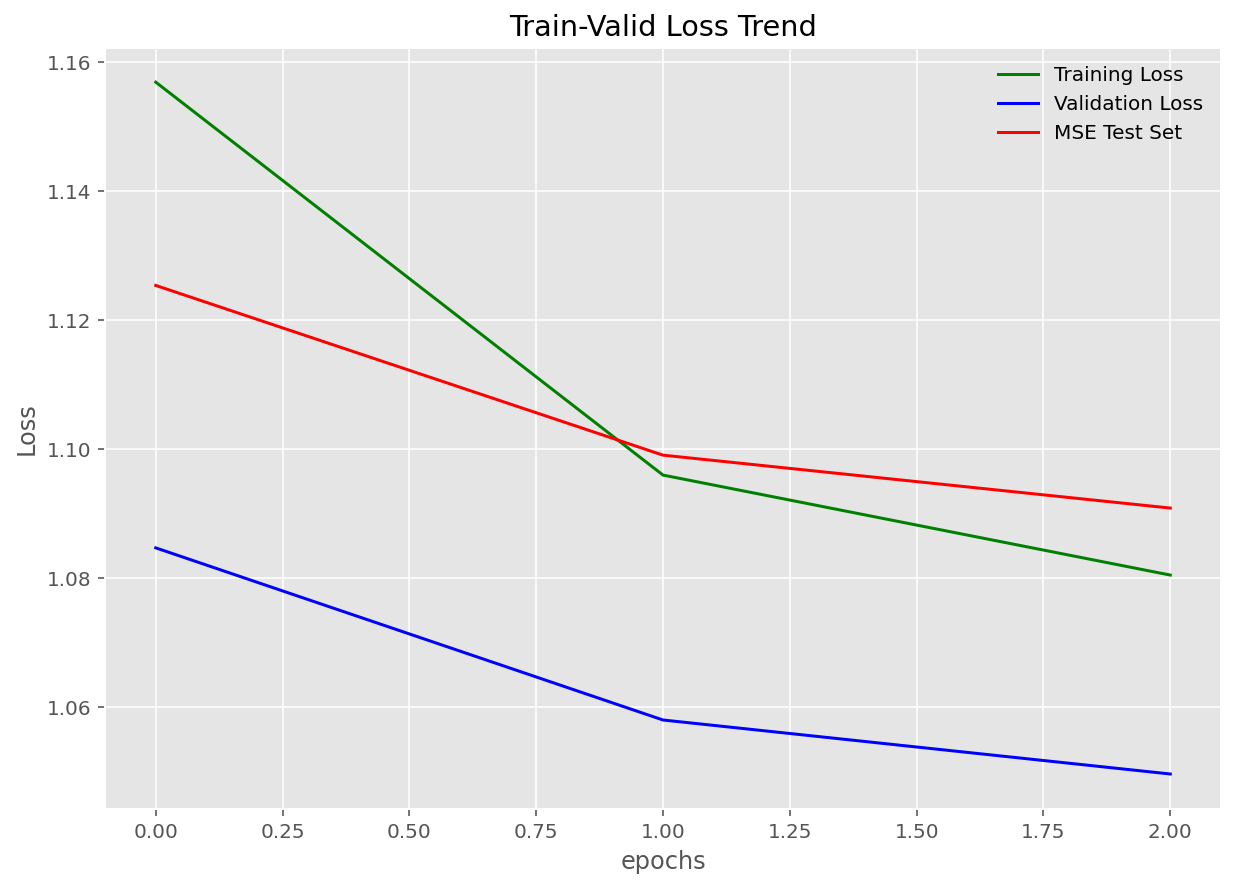

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Loss plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("Train-Valid Loss Trend")
plt.plot(train_losses, color='green', label='Training Loss')
plt.plot(valid_losses, color='blue', label='Validation Loss')
plt.plot(test_mse, color='red', label='MSE Test Set')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(saving_path + "loss_plot.png")
plt.show()

psnr plot...


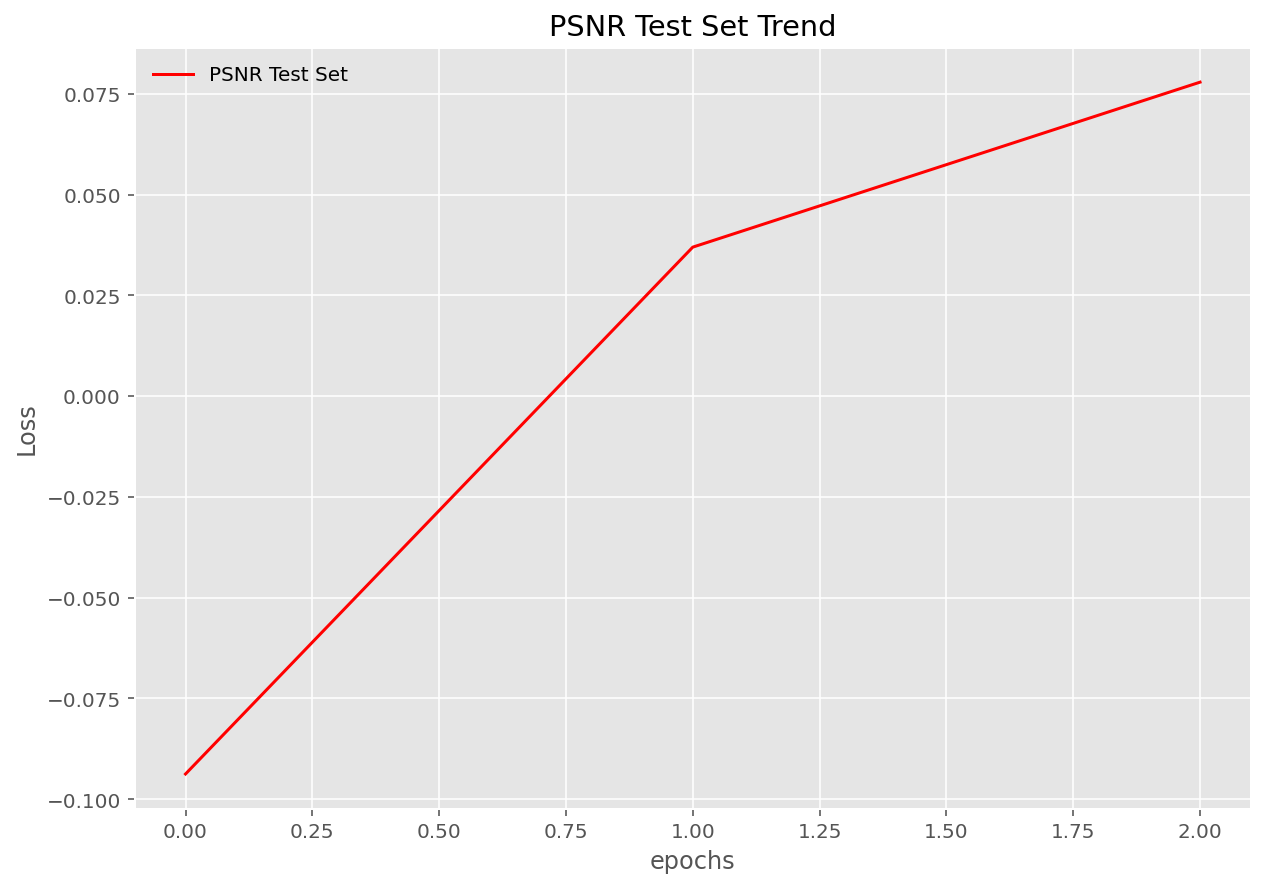

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('psnr plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("PSNR Test Set Trend")
plt.plot(test_psnr, color='red', label='PSNR Test Set')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(saving_path + "psnr_test_plot.png")
plt.show()

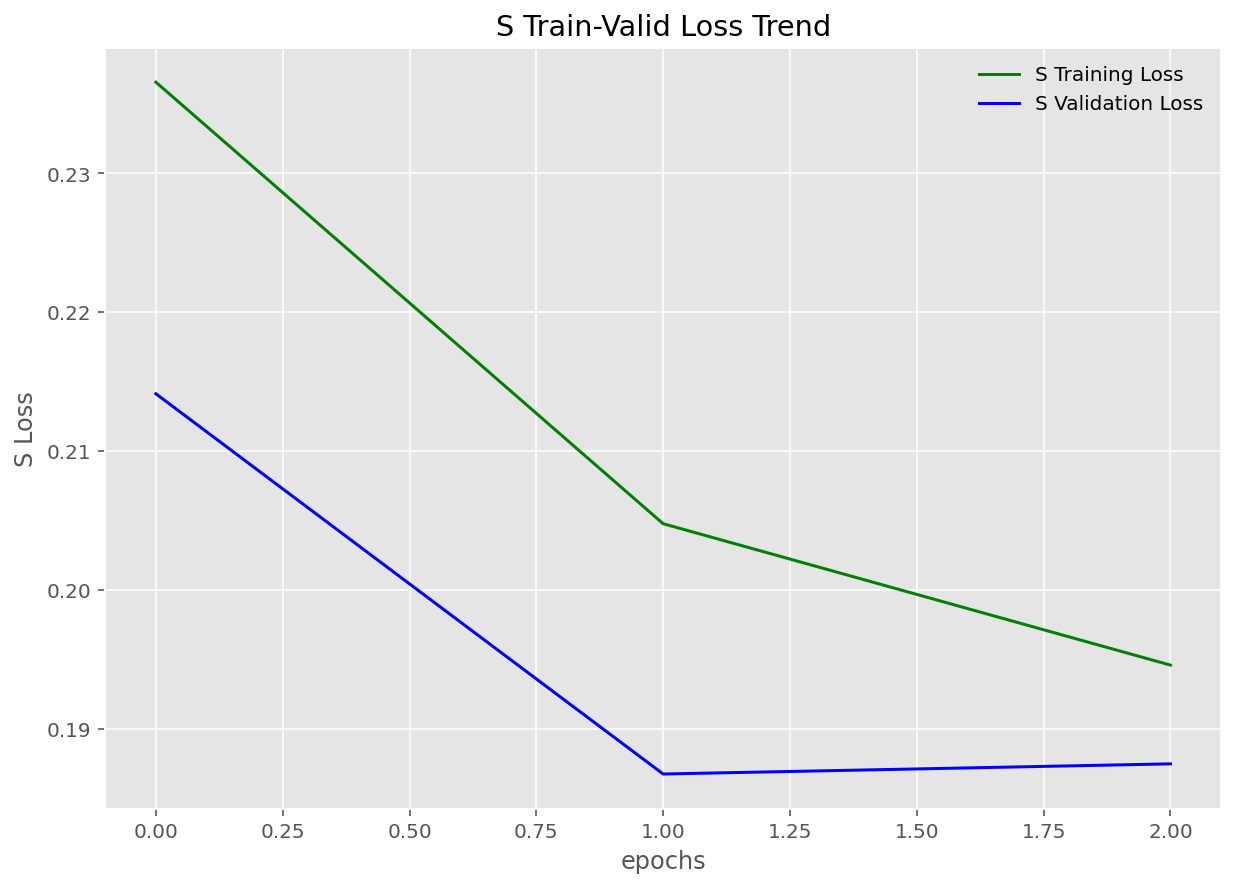

In [ ]:
plt.figure(figsize=(10,7))
plt.title("S Train-Valid Loss Trend")
plt.plot(y1_train_losses, color='green', label='S Training Loss')
plt.plot(y1_valid_losses, color='blue', label='S Validation Loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("S Loss")
plt.savefig(saving_path + "s_loss_plot.png")
plt.show()

In [ ]:
# plt.figure(figsize=(10,7))
# plt.title("Hair Color Train-Valid Loss Trend")
# plt.plot(y2_train_losses[2:], color='green', label='Hair Color Training Loss')
# plt.plot(y2_valid_losses[2:], color='blue', label='Hair Color Validation Loss')
# plt.legend(frameon=False)
# plt.xlabel("epochs")
# plt.ylabel("Hair Color Loss")
# plt.savefig(saving_path + "hair_color_loss_plot.png")
# plt.show()

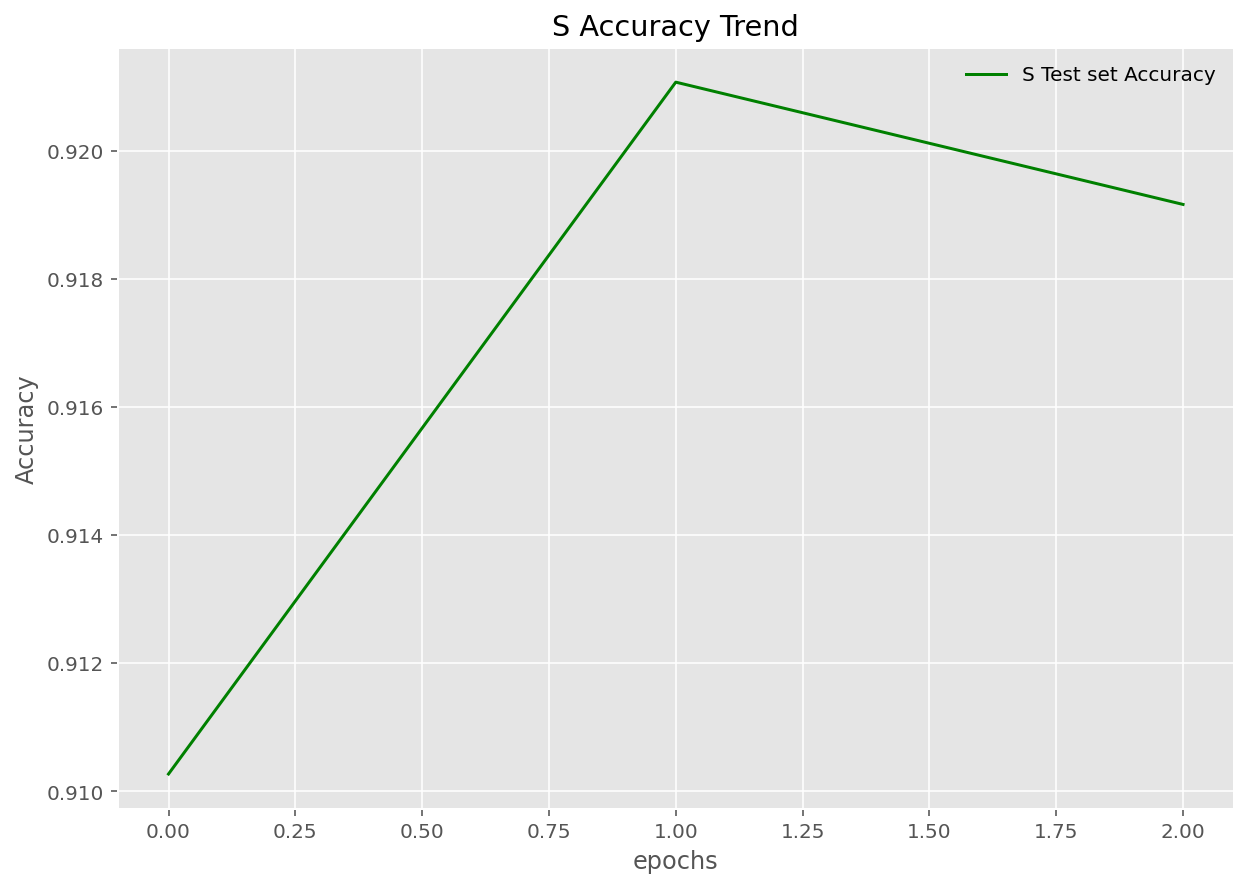

In [ ]:
# test_y2_acc_m = np.array([x.to(torch.device("cpu")).view(3).numpy() for x in test_y2_acc])
plt.figure(figsize=(10,7))
plt.title("S Accuracy Trend")
plt.plot(test_y1_acc, color='green', label='S Test set Accuracy')
# plt.plot(test_y2_acc_m[:,0], color='blue', label='Black Hair Color Test set Accuracy')
# plt.plot(test_y2_acc_m[:,1], color='red', label='Blonde Hair Color Test set Accuracy')
# plt.plot(test_y2_acc_m[:,2], color='orange', label='Brown Hair Color Test set Accuracy')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig(saving_path + "accuracy_test_plot.png")
plt.show()

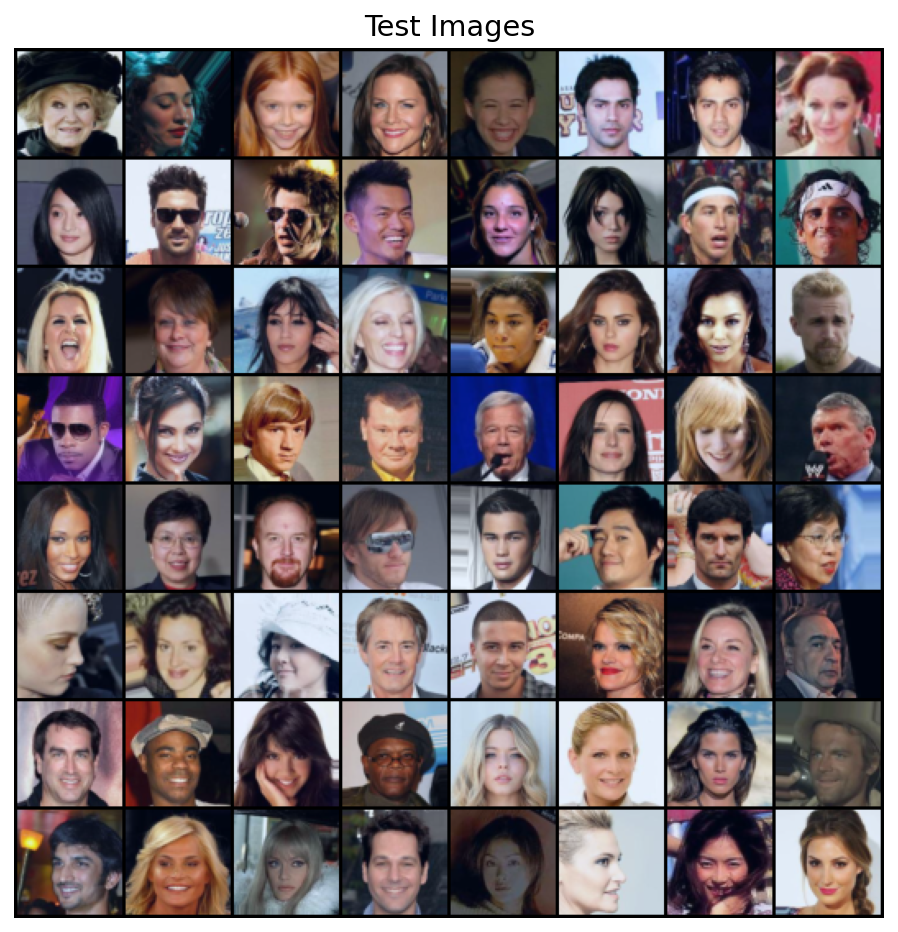

In [ ]:
first_batch = next(iter(test_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# pics = first_batch[0].to(device)[:64]
# reconst_batch, y1, y2 = netAE(pics)
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Reconstructed Images")
# plt.imshow(np.transpose(vutils.make_grid(reconst_batch, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# load_model('ae', 1, netAE, device)
# reconst_batch = netAE(pics)
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Reconstructed Images")
# plt.imshow(np.transpose(vutils.make_grid(reconst_batch, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# test_labels1 = (first_batch[1][0]).to(device)[:,celeba_black_hair_index]
# test_labels2 = (first_batch[1][0]).to(device)[:,celeba_blonde_hair_index]
# test_labels3 = (first_batch[1][0]).to(device)[:,celeba_brown_hair_index]
# hair_color_labels = torch.cat((test_labels1.view(64,1), test_labels2.view(64,1), test_labels3.view(64,1)), 1)
# other_color_labels = torch.add(1, -torch.sum(hair_color_labels,1))
# torch.set_printoptions(precision=1, sci_mode=False)
# hair_color_labels2 = torch.cat((hair_color_labels, other_color_labels.view(64,1)), 1)
# # print(torch.cat((torch.exp(y2), hair_color_labels2),1))
# a,at=torch.exp(y2).topk(1, dim=1)
# b,bt=hair_color_labels2.topk(1, dim=1)
# # print(torch.cat((at, bt),1))
# equals = at == bt
# print(equals.sum().item())
# print(torch.sum(hair_color_labels2,0))

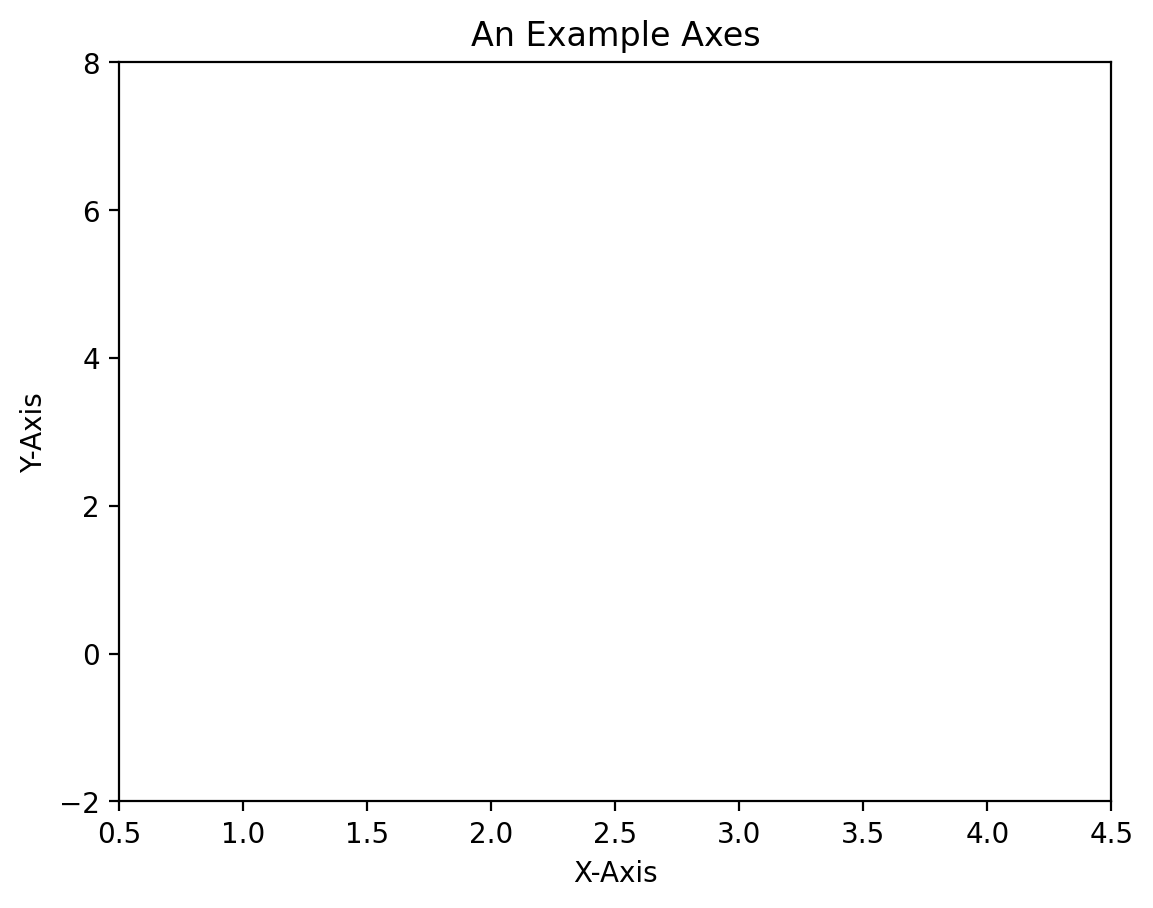

In [ ]:
matplotlib.style.use('default')
fig = plt.figure()
ax = fig.add_subplot(111) # We'll explain the "111" later. Basically, 1 row and 1 column.
ax.set(xlim=[0.5, 4.5], ylim=[-2, 8], title='An Example Axes',
       ylabel='Y-Axis', xlabel='X-Axis')
plt.show()

Loss plot...


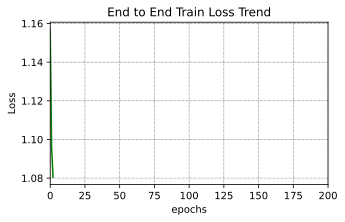

In [ ]:
# e2e Train Loss Plot
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
print('Loss plot...')
# loss plots
fig = plt.figure(figsize=(5,3))
fig.tight_layout()
plt.title("End to End Train Loss Trend")
plt.plot(train_losses, color='green', label='Training Loss')
# plt.plot(valid_losses, color='blue', label='Validation Loss')
# plt.plot(test_mse, color='red', label='MSE Test Set')
# plt.legend(frameon=True)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.xlim([0,200])
plt.grid(color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.savefig(saving_path + "e2e_train_loss_plot.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "e2e_train_loss_plot.png", bbox_inches = 'tight')
plt.savefig(saving_path + "e2e_train_loss_plot.eps", bbox_inches = 'tight', format='eps')
plt.show()

PSNR plot...


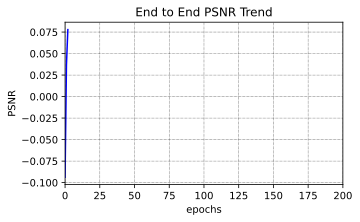

In [ ]:
# e2e PSNR Plot
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
print('PSNR plot...')

fig = plt.figure(figsize=(5,3))
fig.tight_layout()
plt.title("End to End PSNR Trend")
plt.plot(test_psnr, color='blue', label='PSNR')
# plt.plot(valid_losses, color='blue', label='Validation Loss')
# plt.plot(test_mse, color='red', label='MSE Test Set')
# plt.legend(frameon=True)
plt.xlabel("epochs")
plt.ylabel("PSNR")
plt.xlim([0,200])
plt.grid(color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.savefig(saving_path + "e2e_psnr_plot.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "e2e_psnr_plot.png", bbox_inches = 'tight')
plt.savefig(saving_path + "e2e_psnr_plot.eps", bbox_inches = 'tight', format='eps')
plt.show()

Classifier Loss plot...


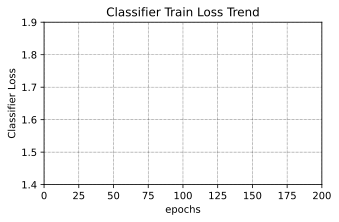

In [ ]:
# classifier train loss Plot
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
print('Classifier Loss plot...')

fig = plt.figure(figsize=(5,3))
fig.tight_layout()
plt.title("Classifier Train Loss Trend")
plt.plot(y1_train_losses, color='red', label='Train Loss')
# plt.plot(valid_losses, color='blue', label='Validation Loss')
# plt.plot(test_mse, color='red', label='MSE Test Set')
# plt.legend(frameon=True)
plt.xlabel("epochs")
plt.ylabel("Classifier Loss")
plt.xlim([0,200])
plt.ylim([1.4,1.9])
plt.grid(color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.savefig(saving_path + "classifier_train_loss_plot.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "classifier_train_loss_plot.png", bbox_inches = 'tight')
plt.savefig(saving_path + "classifier_train_loss_plot.eps", bbox_inches = 'tight', format='eps')
plt.show()